# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [ ]:
!pip install rpy2

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

## load data

In [3]:
def load_and_merge_data(base_dir):
    # 処理する条件（controlとschizophrenia）をリストとして定義
    conditions = ['control', 'schizophrenia']
    
    count=0    
    for condition in conditions:
        condition_path = os.path.join(base_dir, condition)
        
        # 各条件下でのサンプル名（MB7、MB8など）を取得
        samples = os.listdir(condition_path)
        
        for sample in samples:
            sample_path = os.path.join(condition_path, sample, 'matrix.tsv')
            
            # Scanpyのread_csv関数で各matrix.tsvを読み込み
            if count !=0:
                adata_append = sc.read_csv(sample_path, delimiter='\t')
                adata_append = adata_append.T
                print(adata_append.X.shape)
                adata_append.obs['condition'] = condition
                adata_append.obs['sample'] = sample
                # 連結リストに追加
                adata=anndata.concat([adata,adata_append])
                print(adata.X.shape)
                adata.obs_names_make_unique
            else:
                adata = sc.read_csv(sample_path, delimiter='\t')
                adata = adata.T
                print(adata.X.shape)
                adata.obs['condition'] = condition
                adata.obs['sample'] = sample
            
            count+=1 
       
    return adata

In [5]:
import os
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata

def load_and_merge_data(base_dir):
    # 処理する条件（controlとschizophrenia）をリストとして定義
    conditions = ['control', 'schizophrenia']
    
    count = 0
    for condition in conditions:
        condition_path = os.path.join(base_dir, condition)
        
        # 各条件下でのサンプル名（MB7、MB8など）を取得
        samples = os.listdir(condition_path)
        
        for sample in samples:
            sample_path = os.path.join(condition_path, sample, 'matrix.tsv')
            
            # pandasでTSVファイルを読み込み
            df = pd.read_csv(sample_path, delimiter='\t', index_col=0)
            
            # DataFrameからスパース行列に変換
            sparse_matrix = sparse.csr_matrix(df.values)
            
            # スパース行列からAnnDataオブジェクトを作成
            if count == 0:
                adata = sc.AnnData(X=sparse_matrix).T
                print(adata.X.shape)
                adata.obs['condition'] = condition
                adata.obs['sample'] = sample
                
            else:
                adata_append = sc.AnnData(X=sparse_matrix).T
                #print(adata_append.X.shape)
                adata_append.obs['condition'] = condition
                adata_append.obs['sample'] = sample
                
                # 連結
                #adata = anndata.concat([adata, adata_append], join='outer')
                adata = anndata.concat([adata, adata_append])
                adata.obs_names_make_unique
                print(adata.X.shape)
            
            count += 1
            
    return adata

In [6]:
import os
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata

def load_and_merge_data_v3(base_dir):
    # 処理する条件（controlとschizophrenia）をリストとして定義
    conditions = ['control', 'schizophrenia']
    
    count = 0
    for condition in conditions:
        condition_path = os.path.join(base_dir, condition)
        
        # 各条件下でのサンプル名（MB7、MB8など）を取得
        samples = os.listdir(condition_path)
        
        for sample in samples:
            sample_path = os.path.join(condition_path, sample, 'matrix.tsv')
            
            # pandasでTSVファイルを読み込み
            if count == 0:
                adata=sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata.X)
                adata.X = sparse_X
                adata.obs['condition'] = condition
                adata.obs['sample'] = sample
            else:
                adata_append = sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata_append.X)
                adata_append.X = sparse_X
                adata_append.obs['condition'] = condition
                adata_append.obs['sample'] = sample
            
                # 連結
                adata = anndata.concat([adata, adata_append])
                print(adata.X.shape)
            
            count += 1
            
    return adata

In [7]:
base_dir = '/temp/data/human_Sz_PFC_each'
adata = load_and_merge_data_v3(base_dir)
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
print(adata.X.shape)
adata.write(file_path)
#adata = anndata.read_h5ad(file_path)

(20833, 60617)
(31272, 60617)
(38836, 60617)
(48682, 60617)
(58858, 60617)
(68650, 60617)
(78540, 60617)
(83173, 60617)
(91052, 60617)
(99367, 60617)
(106746, 60617)
(116584, 60617)
(127236, 60617)
(135986, 60617)
(146473, 60617)
(156462, 60617)
(165278, 60617)
(175877, 60617)
(182882, 60617)
(189038, 60617)
(197221, 60617)


... storing 'condition' as categorical
... storing 'sample' as categorical


(203786, 60617)
(203786, 60617)


In [10]:
print(adata.X.shape)
adata.obs


(203786, 60617)


,condition,sample
MB11_AAACCCAAGGGACCAT.1,control,MB11
MB11_AAACCCAAGGTATAGT.1,control,MB11
MB11_AAACCCAAGGTGTGAC.1,control,MB11
MB11_AAACCCAAGTCACACT.1,control,MB11
MB11_AAACCCAAGTCATTGC.1,control,MB11
...,...,...
MB8.2_TTTGGTTTCGATTTCT.1,schizophrenia,MB8-2
MB8.2_TTTGTTGCAAAGCACG.1,schizophrenia,MB8-2
MB8.2_TTTGTTGCATCTAGAC.1,schizophrenia,MB8-2
MB8.2_TTTGTTGCATTGTACG.1,schizophrenia,MB8-2


In [4]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
adata = anndata.read_h5ad(file_path)
print(adata.X.shape)

(203786, 60617)


In [3]:
dir="/temp/data/human_Sz_PFC_each/control/MB7"
adata_MB07 = sc.read_csv(os.path.join(dir,"matrix.tsv"),delimiter='\t').T

In [4]:
adata_MB07.obs_names

Index(['MB7_AAACCCAAGATGTTAG.1', 'MB7_AAACCCAAGCAGCCCT.1',
       'MB7_AAACCCAAGTAAGACT.1', 'MB7_AAACCCAAGTCTAGAA.1',
       'MB7_AAACCCACACGACAAG.1', 'MB7_AAACCCACACGTAGTT.1',
       'MB7_AAACCCACATGACTGT.1', 'MB7_AAACCCAGTTCGGGTC.1',
       'MB7_AAACCCATCAAGAATG.1', 'MB7_AAACCCATCAATGCAC.1',
       ...
       'MB7_TTTGGTTGTCTTACTT.1', 'MB7_TTTGGTTGTTTGACAC.1',
       'MB7_TTTGGTTTCGCCGAAC.1', 'MB7_TTTGTTGAGGGCAATC.1',
       'MB7_TTTGTTGAGTAAGACT.1', 'MB7_TTTGTTGCAATGTGGG.1',
       'MB7_TTTGTTGGTATTTCTC.1', 'MB7_TTTGTTGGTCGTCATA.1',
       'MB7_TTTGTTGTCCTGCTAC.1', 'MB7_TTTGTTGTCTGGAAGG.1'],
      dtype='object', length=9838)

In [5]:
adata_MB07.var_names

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'OR4G4P', 'OR4G11P', 'OR4F5', 'AL627309.1',
       ...
       'RF01972.1', 'RF01973.1', 'RF01974.1', 'AC233755.2', 'AC233755.1',
       'AC240274.1', 'RF00003.14', 'RF00003.15', 'AC213203.2', 'AC213203.1'],
      dtype='object', length=60617)

## Set parameters

In [5]:
D_R_mtx=pd.read_csv("/temp/drug_receptor_mtx.csv",index_col=0)
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

drug_list=D_R_mtx.index.to_list()
GPCR_list=["HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]
D_R_mtx.columns=GPCR_list

In [12]:
print(D_R_mtx.index)

print(D_R_mtx.columns)
print(D_R_mtx)

Index(['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE',
       'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE', 'CLOZAPINE'],
      dtype='object', name='Ligand')
Index(['HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A',
       'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5',
       'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5',
       'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2'],
      dtype='object')
                      HTR1A        HTR1B        HTR1D   HTR1E       HTR2A  \
Ligand                                                                      
CHLORPROMAZINE  2373.279902  1489.000000   452.000000   344.0    9.486214   
FLUPHENAZINE     948.761678   334.000000   334.000000   540.0   20.782824   
HALOPERIDOL     2777.025429  4918.285714  6544.666667  7500.0   94.535842   
ZOTEPINE         384.306941   353.000000   106.000000   700.0    2.281467   
RISPERIDONE      334

In [ ]:
print(D_R_mtx)

In [6]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CX3CR1","CLDN5","GLUL","NDRG2","PCDH15","PLP1","MBP","SATB2","SLC17A7",
"SLC17A6","GAD2","GAD1","SNAP25"] # Marker genes for visualization
#print(d_r_column_rep[1:])
markers.extend(GPCR_list)
markers = [str.upper() for str in markers]
markers.remove("HTR1E")
# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [ ]:
start = time.time()

## Load and Preprocess Data

We load the sparse count matrix from an `csv` file using Scanpy. 

In [ ]:
preprocess_start = time.time()

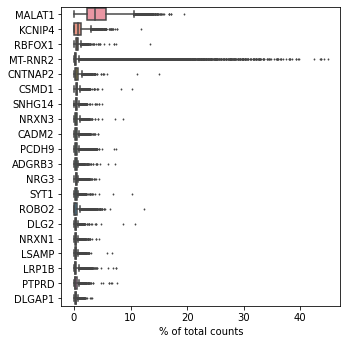

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

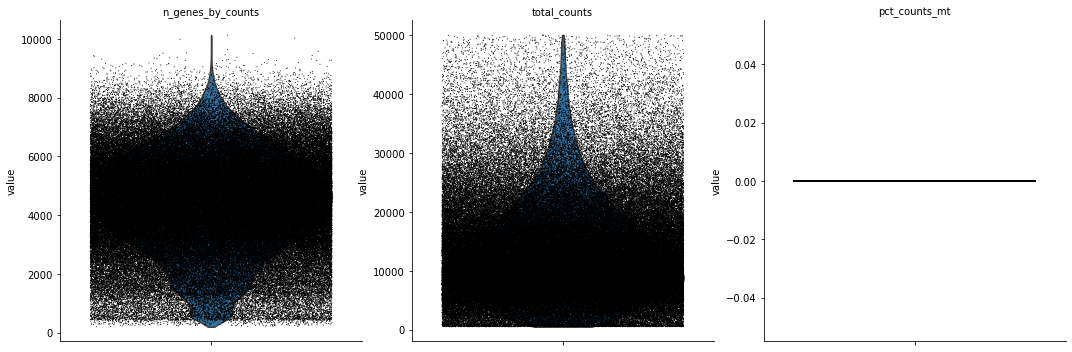

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

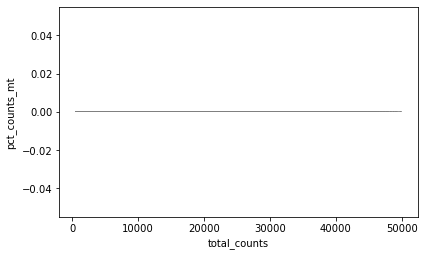

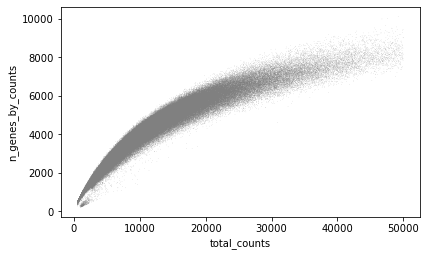

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
genes = cudf.Series(adata.var_names).str.upper()
print(genes)
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

0            DDX11L1
1             WASH7P
2          MIR6859-1
3        MIR1302-2HG
4          MIR1302-2
            ...     
60612     AC240274.1
60613     RF00003.14
60614     RF00003.15
60615     AC213203.2
60616     AC213203.1
Length: 60617, dtype: object


Verify the shape of the resulting sparse matrix:

In [ ]:
sparse_gpu_array.shape

And the number of non-zero values in the matrix:

In [ ]:
sparse_gpu_array.nnz

In [12]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 3.79 s, sys: 2.21 s, total: 6.01 s
Wall time: 6.01 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=min_cells_per_gene)

CPU times: user 5.2 s, sys: 445 ms, total: 5.64 s
Wall time: 5.66 s


The size of our count matrix is now reduced.

In [ ]:
sparse_gpu_array.shape

In [14]:
import pandas as pd
df=genes.to_pandas()
for marker in markers:
    if not marker in df.values:
        print("%s is not included"%marker)
        markers.remove(marker)
        print("%s is removed from marker list"%marker)

HTR1A is not included
HTR1A is removed from marker list


In [15]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 1.09 s, sys: 457 ms, total: 1.55 s
Wall time: 1.53 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [16]:
%%time
mito_genes = genes.str.startswith(MITO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 54.2 ms, sys: 0 ns, total: 54.2 ms
Wall time: 52.9 ms


And perform regression:

In [17]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array.tocsc(), n_counts, percent_mito)
del n_counts, percent_mito, mito_genes

CPU times: user 46min 28s, sys: 2min 11s, total: 48min 40s
Wall time: 48min 39s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [18]:
%%time
mean = sparse_gpu_array.mean(axis=0)
sparse_gpu_array -= mean
stddev = cp.sqrt(sparse_gpu_array.var(axis=0))
sparse_gpu_array /= stddev
sparse_gpu_array = sparse_gpu_array.clip(a_max=10)
del mean, stddev

In [ ]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [ ]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
del sparse_gpu_array, genes

In [ ]:
print(marker_genes_raw)

In [ ]:
%%time
GPCR_df=pd.DataFrame()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    if   name[:-4] in GPCR_list:
        GPCR_df[name]=data.get()

In [ ]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata_regressed.h5ad"
adata.write(file_path)
#adata = anndata.read_h5ad(file_path)

In [ ]:
GPCRdf_path="/temp/data/human_Sz_PFC_each/WT_NAc_scRNA_GPCR_raw_df.csv"
GPCR_df.to_csv(GPCRdf_path)
#GPCR_df=pd.read_csv(GPCRdf_path,index_col=0)

## Calculate response to antipsychotics in each cells

In [ ]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
print(GPCR_adata.X.shape)
#GPCR_adata.obs=pd.DataFrame(GPCR_df.index)
#GPCR_adata.var=pd.DataFrame(GPCR_df.columns)

file_path="/temp/data/human_Sz_PFC_each/WT_NAc_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

In [ ]:
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
dir="/temp/data/human_Sz_PFC_each/"
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
GPCR_adata_norm_df.to_csv(os.path.join(dir,"GPCR_adata_norm_df.csv"))

In [ ]:
#sc.pp.normalize_total(GPCR_adata,target_sum=1e4)
sc.pp.neighbors(GPCR_adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')


In [ ]:

sc.tl.umap(GPCR_adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

In [ ]:
%%time
sc.tl.louvain(GPCR_adata, flavor='rapids')
GPCR_adata.obs['leiden'] = rapids_scanpy_funcs.leiden(GPCR_adata)


In [ ]:
print(GPCR_adata.obsm["X_umap"])
print(GPCR_adata.obs["louvain"])
print(GPCR_adata.obs["leiden"])

In [ ]:
#sc.pl.umap(GPCR_adata,color="leiden")

In [ ]:
norm_df=pd.DataFrame(GPCR_adata_norm)
norm_col=[str[:-4] for str in GPCR_df.columns]
#print(norm_col)
norm_df.columns=norm_col
print(norm_df)

In [ ]:
print(GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)])
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]

In [ ]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

#print(Gs)
#print(GPCR_adata_norm)
drug_list=D_R_mtx.index.to_list()
#print(drug_list)
#drug_receptor_mtx
cAMP_df=pd.DataFrame(columns=drug_list)
Ca_df=pd.DataFrame(columns=drug_list)
for drug in drug_list:
    Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
    Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
    Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
    cAMPmod=Gi_effect-Gs_effect #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下
    Camod=-Gq_effect #Gq阻害→Ca低下
    cAMP_df[drug]=cAMPmod
    Ca_df[drug]=Camod

In [ ]:
cAMP_df.index=adata.obs_names
Ca_df.index=adata.obs_names
Ca_df=Ca_df+10**(-4)
for drug in drug_list:
    adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
    adata.obs['Ca_%s'%drug]=Ca_df[drug]

In [ ]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
adata.write(file_path)

### UMAP + Graph clustering

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [ ]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

The UMAP function from Rapids is also integrated into Scanpy.

In [ ]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

Next, we use the Louvain algorithm for graph-based clustering.

In [ ]:
%%time
sc.tl.louvain(adata, flavor='rapids')

We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

In [ ]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also use the Leiden clustering method in RAPIDS. This method has not been integrated into Scanpy and needs to be called separately.

In [ ]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

In [ ]:
%%time
sc.pl.umap(adata, color=["leiden"])

In [ ]:
for drug in drug_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'wspace':0.2})
    ax1_dict = sc.pl.umap(adata, color=["cAMP_%s"%drug],norm=LogNorm(),ax=ax1, show=False)
    ax2_dict = sc.pl.umap(adata, color=["Ca_%s"%drug],norm=LogNorm(),ax=ax2, show=False)

And we can visualize the cells labeled by expression of the `Stmn2` and `Hes1` marker genes, for neuronal and glial cells respectively.

In [ ]:
%%time
#sc.pl.umap(adata, color=["Etv1_raw"], color_map="Reds", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Nos1_raw"], color_map="Reds", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Gad1_raw"], color_map="Blues", vmax=1, vmin=-0.05)
#sc.pl.umap(adata, color=["Glp1r_raw"], color_map="Blues", vmax=1, vmin=-0.05)
for marker in markers:
    sc.pl.umap(adata, color=["%s_raw"%marker], color_map="Blues", vmax=1, vmin=-0.05)

In [ ]:
adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
print(sum(adata.obs["is_clz_activated"]))

In [ ]:
adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")
print(sum(adata.obs["is_clz_inhibited"]))

In [ ]:
drug_list2=drug_list.copy()
drug_list2.remove("CLOZAPINE")
print(drug_list2)

for idx,drug in enumerate(drug_list2):
    #print(idx)
    if idx==0:
        cAMP_mean=adata.obs["cAMP_%s"%drug]
    else:
        cAMP_mean=cAMP_mean+adata.obs["cAMP_%s"%drug]
    #print(adata.obs["cAMP_%s"%drug])
cAMP_mean=cAMP_mean/len(drug_list2)
print(cAMP_mean)
adata.obs["cAMP_mean_other_than_czp"]=cAMP_mean
adata.obs["cAMP_clz_selectivity"]=adata.obs["cAMP_CLOZAPINE"]**2/cAMP_mean**2
print(sum(adata.obs["cAMP_clz_selectivity"]>1.5))

In [ ]:
selectivity_threshold=1.5
adata.obs["is_clz_selective"]=np.zeros(len(adata.obs))
adata.obs["is_clz_selective"][(adata.obs["cAMP_clz_selectivity"]>1.5)&(adata.obs["cAMP_CLOZAPINE"]>0)]=1
adata.obs["is_clz_selective"]=adata.obs["is_clz_selective"].astype("category")
print(sum(adata.obs["is_clz_selective"]))

In [ ]:
print(cAMP_mean_other_than_czp)

In [ ]:
sc.pl.umap(adata, color=["is_clz_activated"])

In [ ]:
sc.pl.umap(adata, color=["is_clz_inhibited"])

In [ ]:
print(adata.obs["is_clz_activated"].dtype)

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,6), gridspec_kw={'wspace':0.2})
sc.pl.umap(adata, color=["is_clz_selective"],ax=ax1,palette=["gray","red"])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.pdf",bbox_inches='tight')
fig.savefig("../data/mouse_PFC/pdf/clz_selective_scatter.png",bbox_inches='tight')
plt.close()

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_activated', method='wilcoxon')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False,save="clz_selective_over_olz_genes_mouse_PFC.pdf")

In [ ]:
file_path="/temp/data/mouse_PFC/WT_PFC_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

In [ ]:
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
adata.write(file_path)

In [ ]:
adata.obs

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_inhibited', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

In [ ]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [ ]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

In [ ]:
%%time
for drug in drug_list:
    sc.pl.violin(adata, "cAMP_%s"%drug, groupby='leiden',stripplot=True,log=True)